In [2]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116932 sha256=22a1a370bf0560fa73ec393758eeea965fcdb8e1a08292173638d3c852ef21f0
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [3]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import os
import torch

from medmnist import dataset
from medmnist import INFO

In [31]:
# Define params for the NN training
n_epochs = 200
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = -1
latent_dim = 100
n_classes = 11
img_size = 32
channels = 1
sample_interval = 400

In [ ]:

img_shape = (channels, img_size, img_size)
os.makedirs("images", exist_ok=True)
cuda = True if torch.cuda.is_available() else False

In [32]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            nn.Linear(512, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512)
            )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity


# Loss functions
adversarial_loss = torch.nn.MSELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
data_dir = "../../data/medmnist"  # Path to the MedMNIST dataset directory
os.makedirs(data_dir, exist_ok=True)
# dataloader = torch.utils.data.DataLoader(datasets.MNIST(
#     "../../data/mnist",
#     train=True,
#     download=True,
#     transform=transforms.Compose(
#         [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
#     ),
# ),
#     batch_size=batch_size,
#     shuffle=True,
# )
dataloader = torch.utils.data.DataLoader(
    dataset.OrganAMNIST(
        # root=data_dir,
        split='train',
        transform=transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ]),
        target_transform=transforms.Lambda(lambda x: x[0]),
        # flag=dataset_name,
        download=True
    ),
    batch_size=batch_size,
    shuffle=True
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor


def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)


# ----------
#  Training
# ----------

for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            sample_image(n_row=n_classes, batches_done=batches_done)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
[Epoch 38/200] [Batch 68/136] [D loss: 0.214788] [G loss: 0.330668]
[Epoch 38/200] [Batch 69/136] [D loss: 0.198726] [G loss: 0.366564]
[Epoch 38/200] [Batch 70/136] [D loss: 0.195998] [G loss: 0.364969]
[Epoch 38/200] [Batch 71/136] [D loss: 0.193264] [G loss: 0.384291]
[Epoch 38/200] [Batch 72/136] [D loss: 0.183267] [G loss: 0.413951]
[Epoch 38/200] [Batch 73/136] [D loss: 0.183619] [G loss: 0.423506]
[Epoch 38/200] [Batch 74/136] [D loss: 0.166649] [G loss: 0.415086]
[Epoch 38/200] [Batch 75/136] [D loss: 0.165929] [G loss: 0.445948]
[Epoch 38/200] [Batch 76/136] [D loss: 0.145209] [G loss: 0.513054]
[Epoch 38/200] [Batch 77/136] [D loss: 0.149959] [G loss: 0.508993]
[Epoch 38/200] [Batch 78/136] [D loss: 0.147301] [G loss: 0.519068]
[Epoch 38/200] [Batch 79/136] [D loss: 0.168179] [G loss: 0.471552]
[Epoch 38/200] [Batch 80/136] [D loss: 0.165513] [G loss: 0.451167]
[Epoch 38/200] [Batch 81/136] [D loss: 0.188590] 

KeyboardInterrupt: ignored

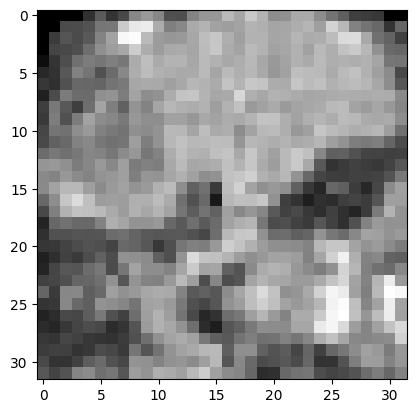

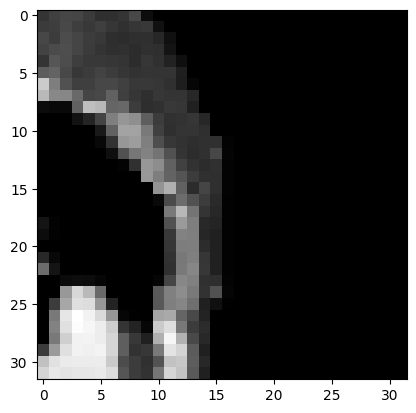

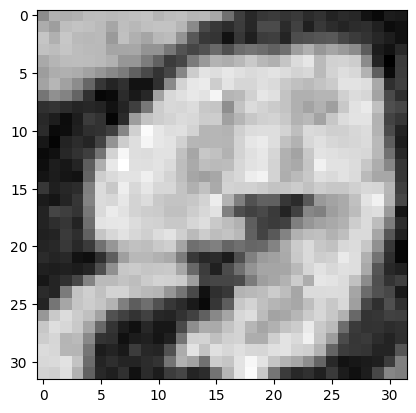

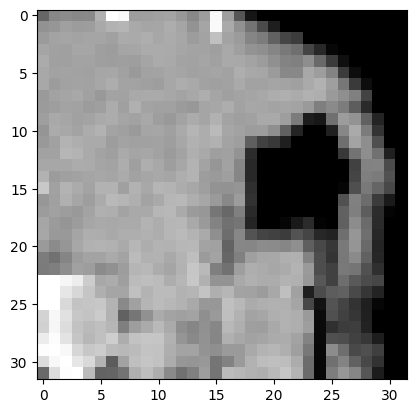

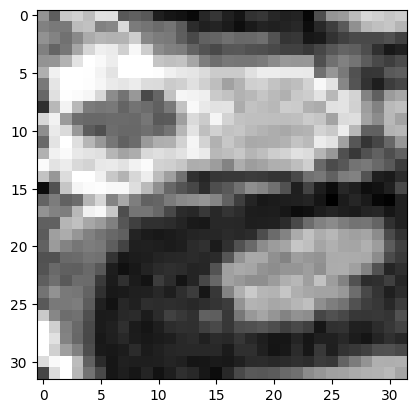

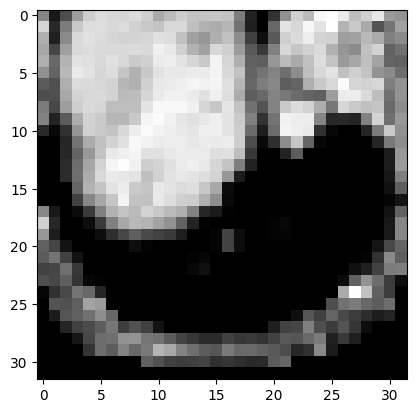

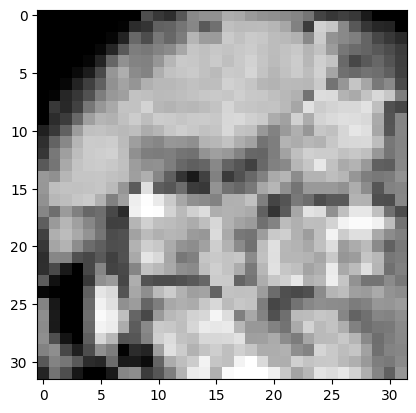

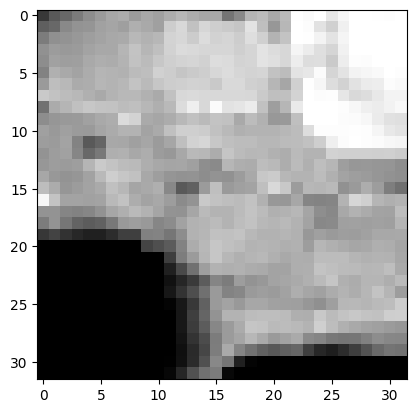

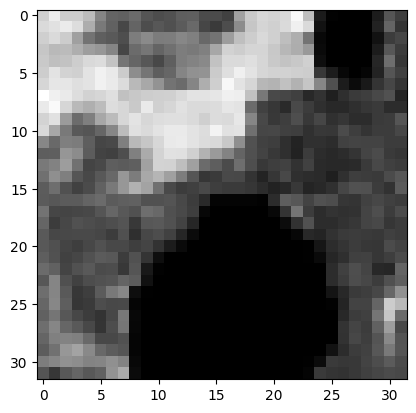

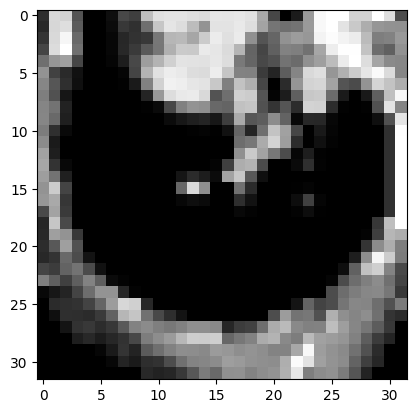

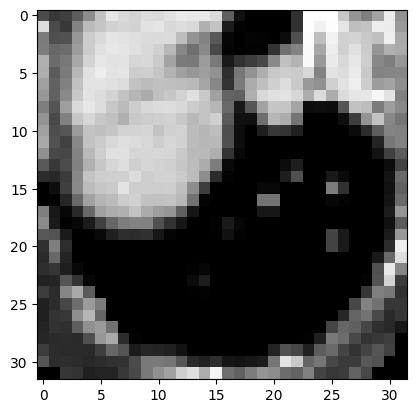

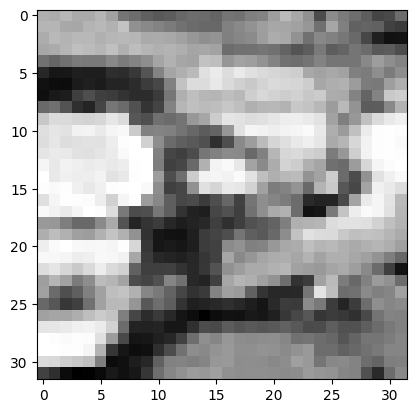

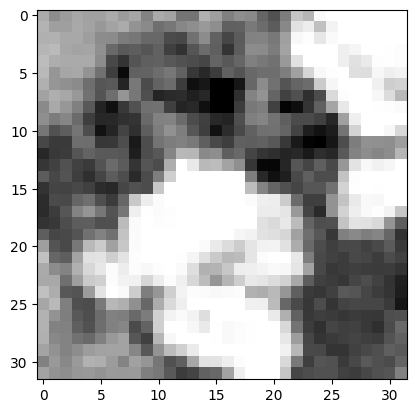

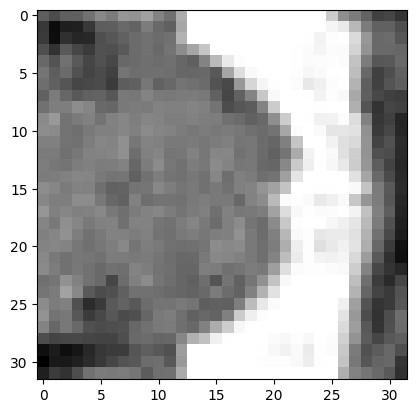

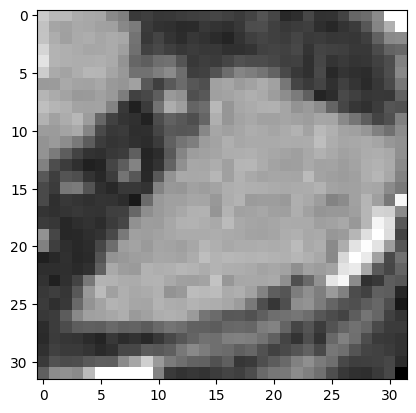

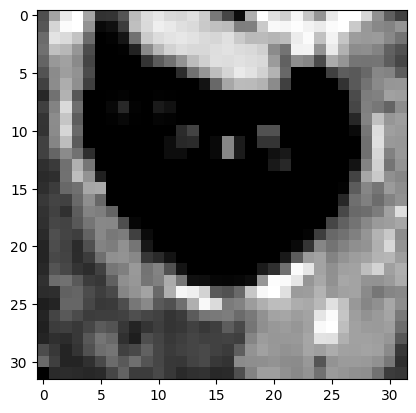

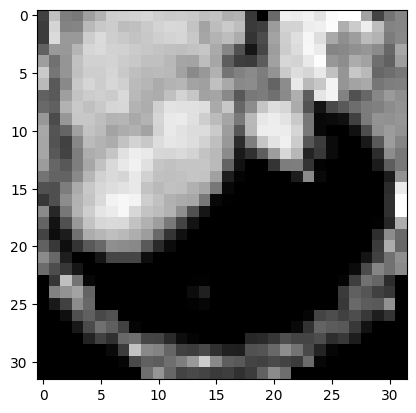

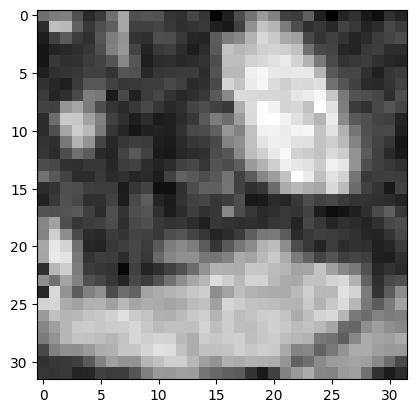

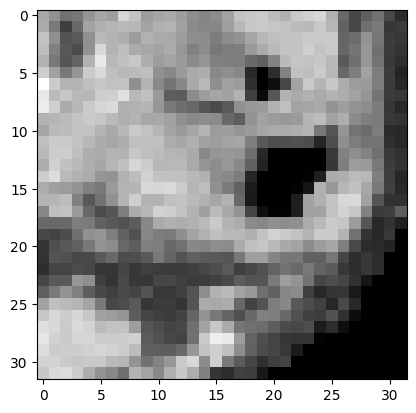

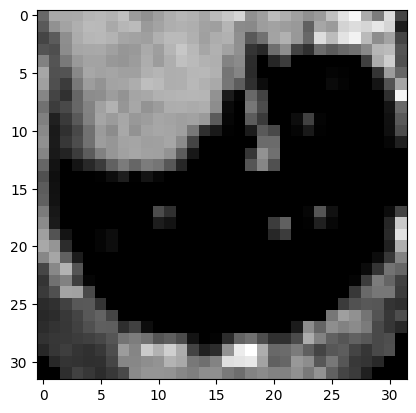

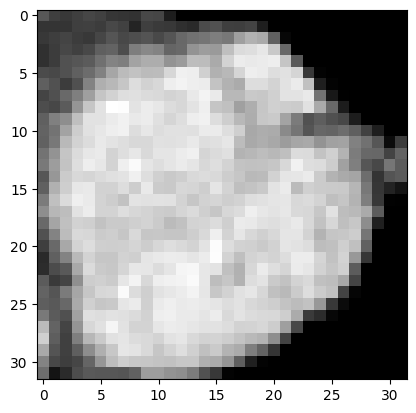

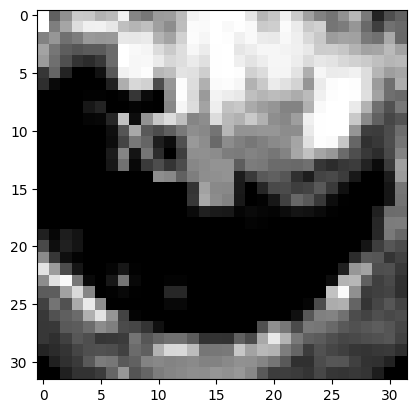

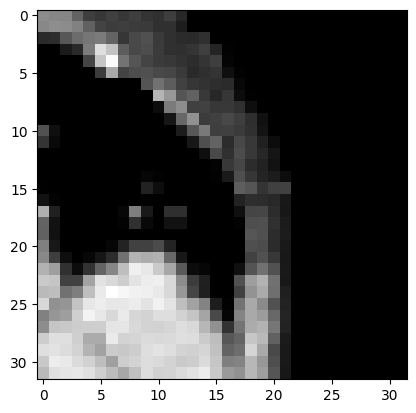

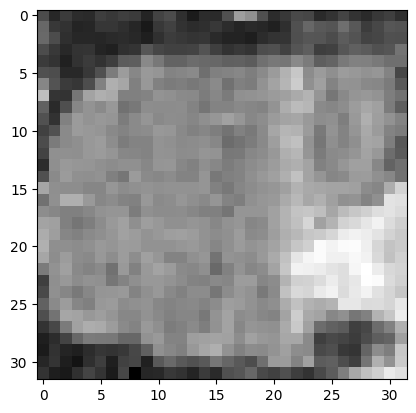

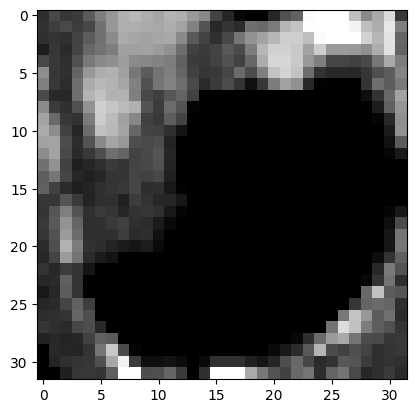

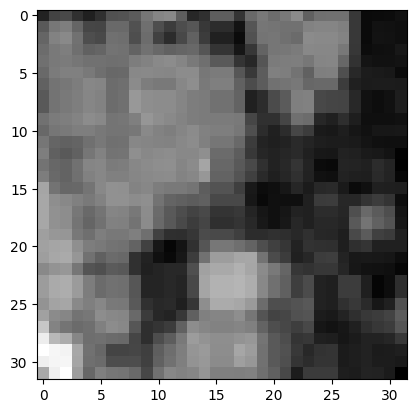

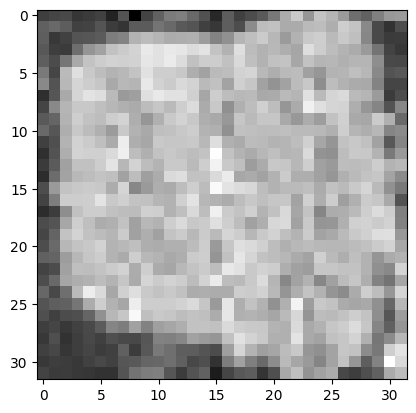

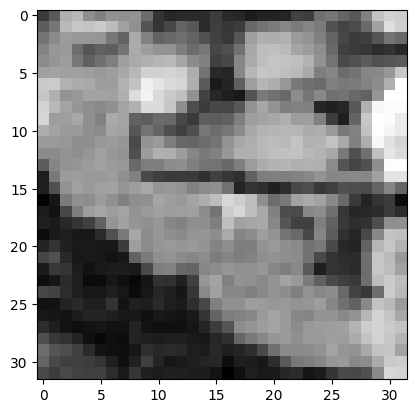

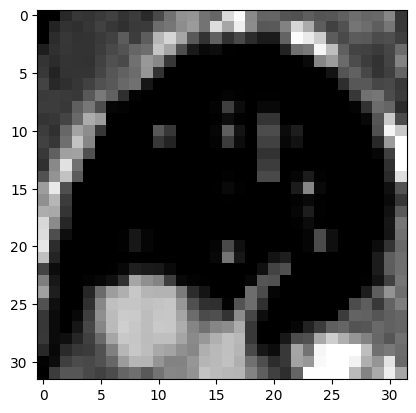

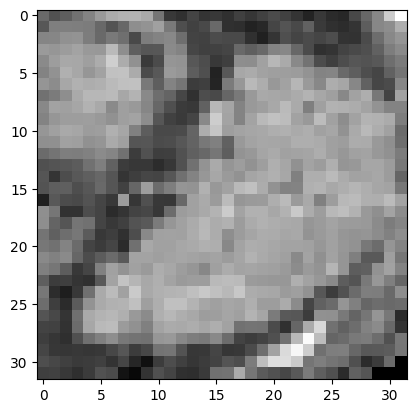

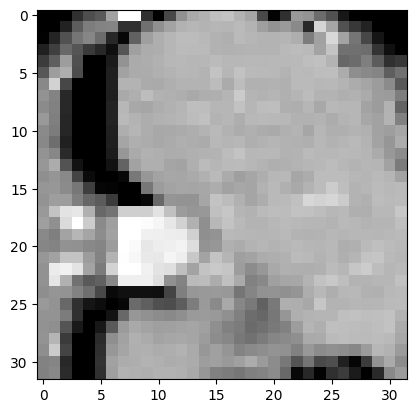

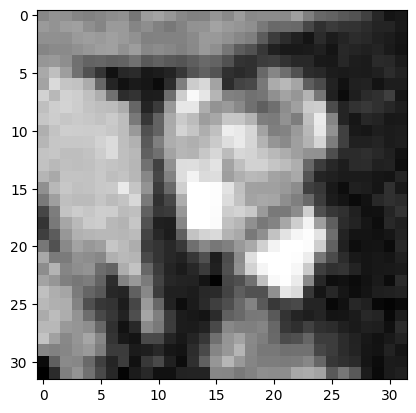

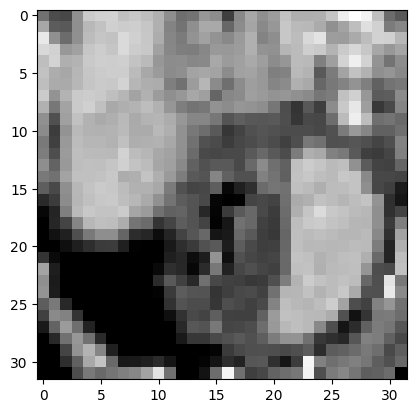

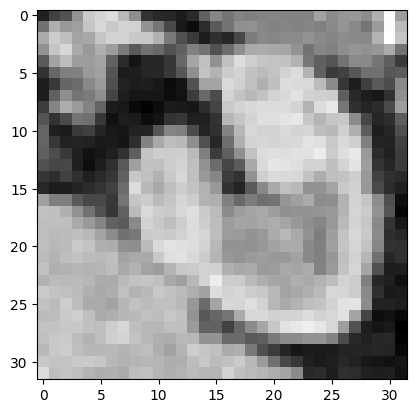

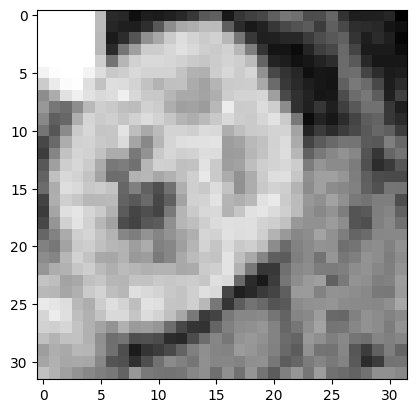

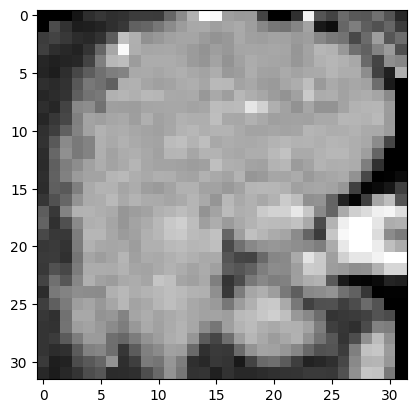

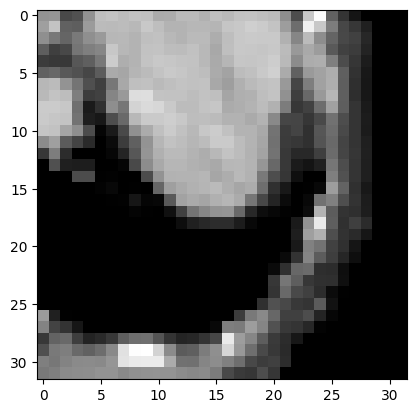

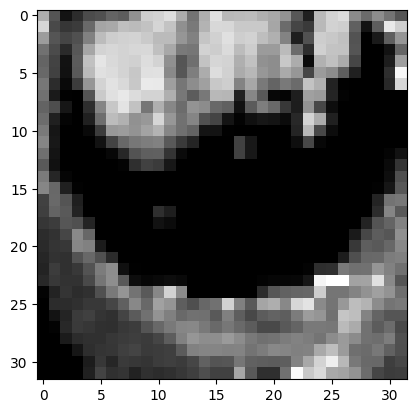

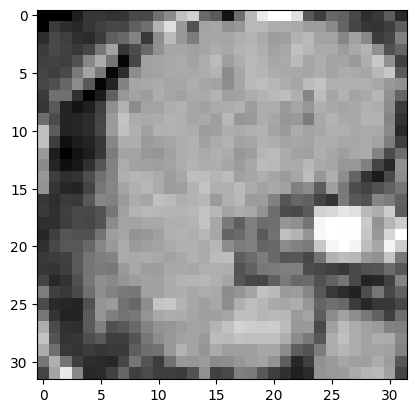

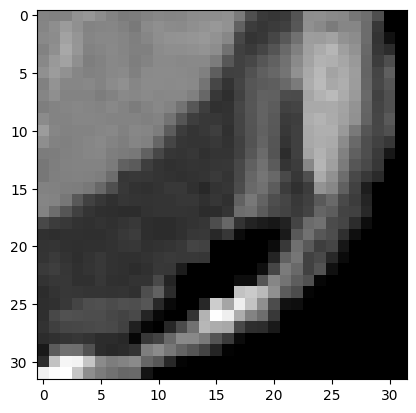

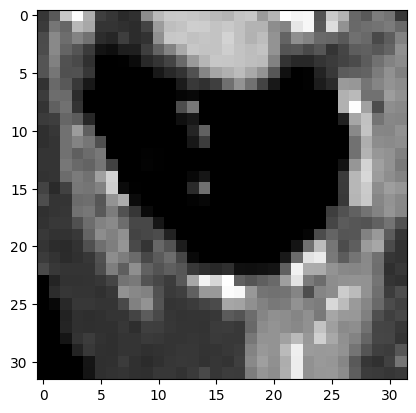

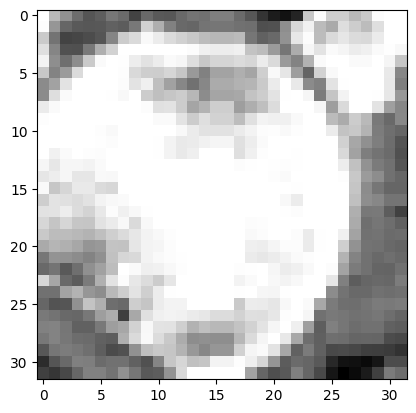

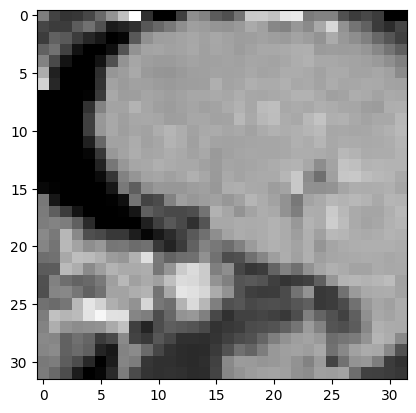

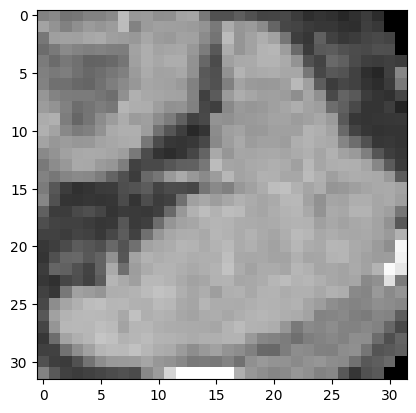

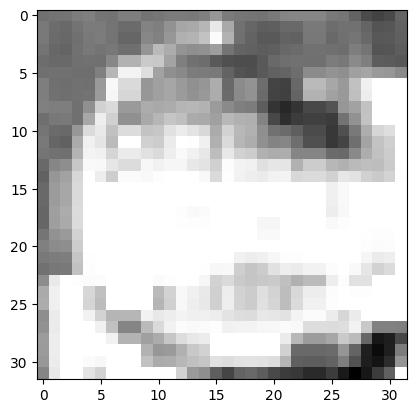

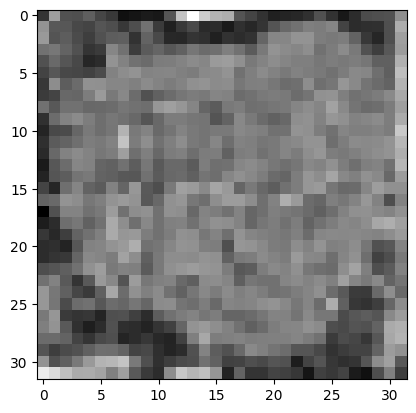

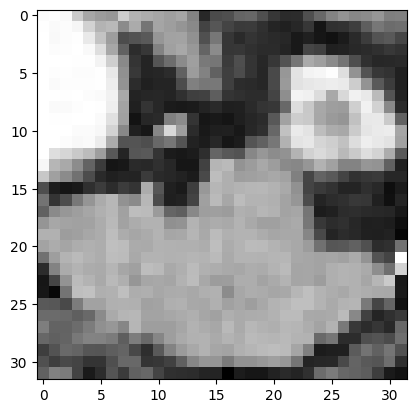

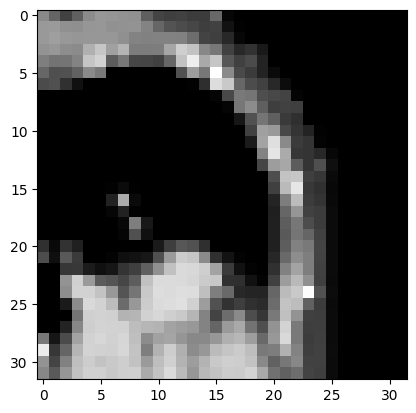

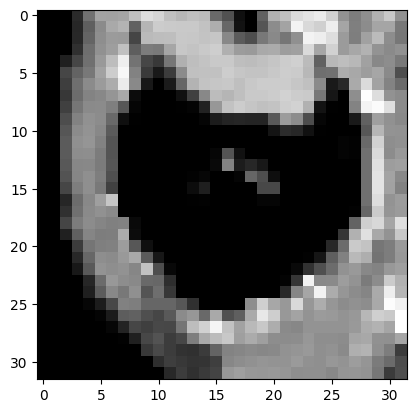

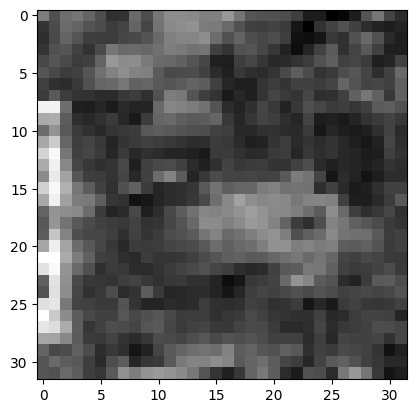

In [41]:
import matplotlib.pyplot as plt


# Create a random 1x32x32 tensor
for i in range(50):
  tensor = dataloader.dataset[i][0]

  # Convert the tensor to a numpy array
  array = tensor.numpy()

  # Reshape the array to 32x32
  reshaped_array = array.reshape(32, 32)

  # Plot the array as an image
  plt.imshow(reshaped_array, cmap='gray')
  plt.show()